In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pathlib
import cv2
import random
import math
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

In [4]:
img_height = 128         # The desired height of images
img_width  = 128         # The desired width of images
epoches    = 15          # No of epochs in training process
num_classes = 0          # No of classes in dataset, Will be initialized later below

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
data_dir = pathlib.Path('/content/drive/MyDrive/data')        # 'data' is the name of the folder with dataset
print(f"There are a total of {len(list(data_dir.glob('*/*.jpeg')))} images in dataset.")

There are a total of 40 images in dataset.


In [7]:
#A function defined to read datasst from data folder, It iterates over all sub directories of given root directory
#and read and resize all images in them
#args - root_folder : The root folder of dataset
#return - classes : Classes in dataset
#       - images  : Actuall data
#       - labels  : Labels of data
def create_dataset(root_folder):
    classes = {}
    images = []
    labels = []
    for dir in os.listdir(root_folder):
        for file in os.listdir(os.path.join(root_folder, dir)):
            image_path = os.path.join(root_folder, dir, file)         #image path
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)          #read color image
            image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21) #Reduce noise (https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_photo/py_non_local_means/py_non_local_means.html)
            image = cv2.resize(image, (img_height, img_width))        #resize image
            image = np.array(image)                                   #change image into numpy array
            image = image.astype('float32')                           #set type as float, for future division
            image /= 255.0                                            #diviing by 25 to normalize the pixel to [0,1]
            images.append(image)                                      #add image to imges
            labels.append(dir)                                        #add dir name to label, dir name is class label
    
    unique_labels = np.unique(labels)                                 #get unique labels
    for i in range(len(unique_labels)):                               #create dictionary of class label and identifier
        classes[unique_labels[i]] = i
        
    labels = [classes[item] for item in labels]      #change class labels to class identifier, e.g o-> 0, x->1
    
    return classes, images, labels

In [8]:
#read dataset and get classes, images and labels
classes, images, labels = create_dataset(data_dir)

#set value for num_classes
num_classes = len(classes)

print(f'Classes in dataset are {classes}')

Classes in dataset are {'o': 0, 'x': 1}


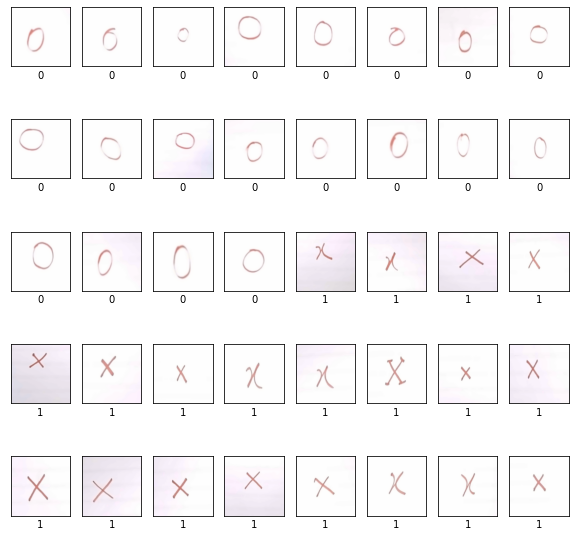

In [9]:
plt.figure(figsize=(10, 10))
for i in range(len(images)):
    plt.subplot(math.ceil(len(images)/8), 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images[i])
    plt.xlabel(labels[i])
plt.show()

In [10]:
#The test size is 0.2 i.e 20% of actuall data
train_ds, test_ds, train_label, test_label = train_test_split(images, labels, test_size=0.3, random_state= 32)

#The result for above function (train_test_split) is list change it to array for future use
train_ds = np.array(train_ds)
test_ds = np.array(test_ds)
train_label = np.array(train_label)
test_label = np.array(test_label)

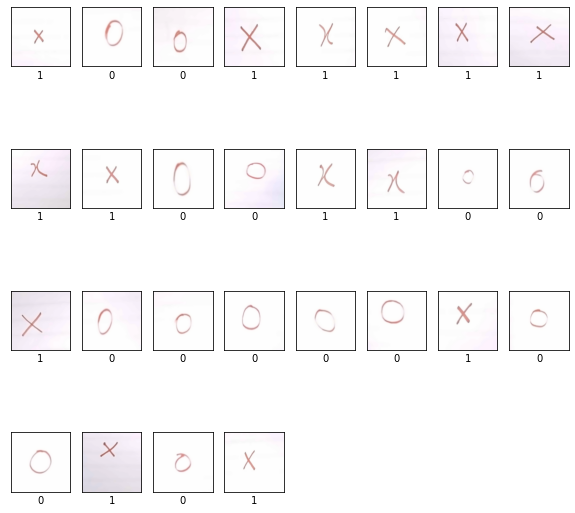

In [12]:
plt.figure(figsize=(10, 10))
for i in range(len(train_ds)):
    plt.subplot(math.ceil(len(train_ds)/8), 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_ds[i])
    plt.xlabel(train_label[i])
plt.show()

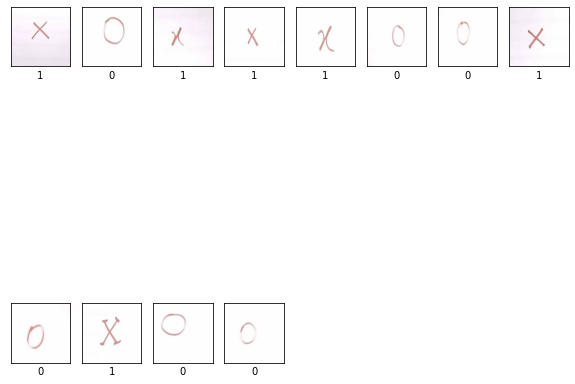

In [13]:
plt.figure(figsize=(10, 10))
for i in range(len(test_ds)):
    plt.subplot(math.ceil(len(test_ds)/8), 8 ,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_ds[i])
    plt.xlabel(test_label[i])
plt.show()

In [19]:
num_classes=2

model = Sequential([
  layers.InputLayer(input_shape=(img_height,img_width,3)),
 
  layers.Conv2D(filters=32,kernel_size=(3,3) ,activation='relu'),
  layers.MaxPooling2D(2,2),
  #layer2
  layers.Conv2D(filters=32,kernel_size=(3,3) ,activation='relu'),
  layers.MaxPooling2D(2,2),
  #layer3
  layers.Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
  layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(32, activation='relu'),
 
 

  layers.Dense(num_classes)

 
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)             

In [20]:
#Compiling model with optimizer = 'adam' and lass function as 'SparseCategoricalCrossentropy'
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

#Finally fit the model and train data and test on test data
history = model.fit(
    train_ds,
    train_label,
    epochs = epoches,
    validation_data = (test_ds, test_label))

Epoch 1/15
1/1 [==============================] - 1s 1s/step - loss: 0.7004 - accuracy: 0.5000 - val_loss: 0.9322 - val_accuracy: 0.5000
Epoch 2/15
1/1 [==============================] - 1s 518ms/step - loss: 0.9306 - accuracy: 0.5000 - val_loss: 0.7205 - val_accuracy: 0.5000
Epoch 3/15
1/1 [==============================] - 1s 526ms/step - loss: 0.7199 - accuracy: 0.5000 - val_loss: 0.6953 - val_accuracy: 0.5000
Epoch 4/15
1/1 [==============================] - 1s 526ms/step - loss: 0.6947 - accuracy: 0.5000 - val_loss: 0.6954 - val_accuracy: 0.5000
Epoch 5/15
1/1 [==============================] - 1s 518ms/step - loss: 0.6946 - accuracy: 0.5000 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 6/15
1/1 [==============================] - 1s 512ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 7/15
1/1 [==============================] - 1s 525ms/step - loss: 0.6929 - accuracy: 0.5000 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 8/15
1/1 [=======

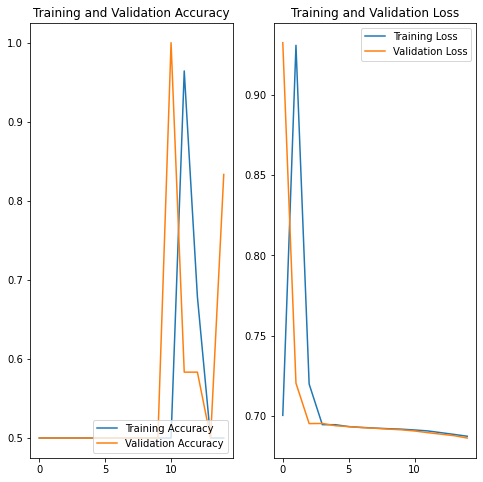

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epoches)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

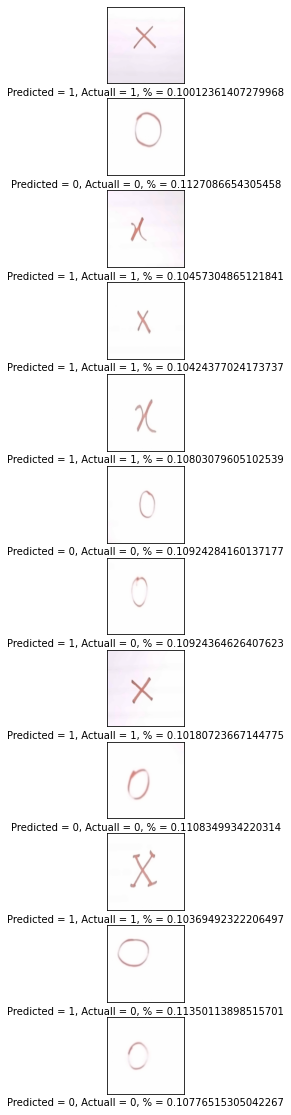

In [22]:
plt.figure(figsize=(20, 20))
for i in range(len(test_ds)):
    
    r  = model.predict(np.expand_dims(test_ds[i], axis=0))[0]
    pr = np.max(r)
    p  = np.argmax(r)
    
    plt.subplot(math.ceil(len(test_ds)), 1 , i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_ds[i])
    plt.xlabel(f'Predicted = {p}, Actuall = {test_label[i]}, % = {abs(pr)}')
plt.show()